In [13]:
import zipfile
import os
import numpy as np
from sklearn.decomposition import PCA
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [3]:
# Unzip the archive
local_zip = 'D:/Code/python/mat3533/practice09/data/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
base_dir = 'D:/Code/python/mat3533/practice09/exercise/cats_and_dogs_filtered'
# Change the base_dir to where you put dataset
print("Contents of base directory:")
print(os.listdir(base_dir))
print("\nContents of train directory:")
print(os.listdir(f'{base_dir}\\train'))
print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}\\validation'))

Contents of base directory:
['train', 'validation', 'vectorize.py']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


In [6]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print("\nContents of train directory:")
print(os.listdir(f'{base_dir}\\train'))
print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}\\validation'))


Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


In [7]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
print(train_cat_fnames[:10])
print(train_dog_fnames[:10])
print('total training cat images :', len(os.listdir( train_cats_dir ) ))
print('total training dog images :', len(os.listdir( train_dogs_dir ) ))
print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']
total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
batch_size=20,
class_mode='binary',
target_size=(150, 150))

# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_images_reshaped = []
for i in range(len(train_generator)):
    batch_images = train_generator[i][0]  # Lấy batch ảnh
    batch_images_reshaped = batch_images.reshape((-1, 150 * 150 * 3))  # Reshape từng ảnh trong batch
    train_images_reshaped.append(batch_images_reshaped)

# Gộp tất cả các ảnh thành một array
train_images_reshaped = np.concatenate(train_images_reshaped, axis=0)

print("Reshaped train images shape:", train_images_reshaped.shape)

# Chuyển tất cả các ảnh từ validation_generator
validation_images_reshaped = []
for i in range(len(validation_generator)):
    batch_images = validation_generator[i][0]  # Lấy batch ảnh
    batch_images_reshaped = batch_images.reshape((-1, 150 * 150 * 3))  # Reshape từng ảnh trong batch
    validation_images_reshaped.append(batch_images_reshaped)

# Gộp tất cả các ảnh thành một array
validation_images_reshaped = np.concatenate(validation_images_reshaped, axis=0)

print("Reshaped validation images shape:", validation_images_reshaped.shape)


Reshaped train images shape: (2000, 67500)
Reshaped validation images shape: (1000, 67500)


Giảm số chiều dữ liệu về 2 chiều

In [10]:
pca = PCA(n_components=2)

pca.fit(train_images_reshaped)

train_images_pca = pca.transform(train_images_reshaped)
validation_images_pca = pca.transform(validation_images_reshaped)

print("Shape of train images after PCA:", train_images_pca.shape)
print("Shape of validation images after PCA:", validation_images_pca.shape)


Shape of train images after PCA: (2000, 2)
Shape of validation images after PCA: (1000, 2)


In [12]:
def kmeans_display(X, label):
    K = np.amax(label) + 1
    for k in range(K):
        Xk = X[label == k, :]
        plt.plot(Xk[:, 0], Xk[:, 1], 'o', label='Cluster {}'.format(k))
    plt.axis('equal')
    plt.legend()

    plt.show()

def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) ==
    set([tuple(a) for a in new_centers]))

def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break

        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Centers found by our algorithm:
[[ 23.73836899  -0.05253697]
 [-21.91254807   0.04858381]]


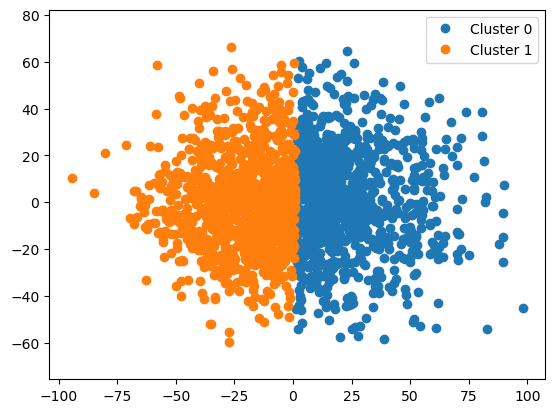

In [14]:
K = 2
(centers, labels, it) = kmeans(train_images_pca, K)
print('Centers found by our algorithm:')
print(centers[-1])
kmeans_display(train_images_pca, labels[-1])